For introduction and problem statement, please refer to notebook 1

## Content

**Notebook 1: 1_cellphones_reviews_data_cleaning_and_eda**
- Data Import and Cleaning
- Exploratory Data Analysis
- Text Data Pre-processing

**Notebook 2: 2_cellphones_reviews_topic modelling**
- Data Import
- Topic Modelling with Gensim

**Notebook 3: 3_cellphones_reviews_topic_analysis_and_visualizations**
- [Findings and Analysis of Topic Modelling](#Findings-and-Analysis-of-Topic-Modelling)

**Notebook4**
- Sentiment Analysis (Logistic Regression Classifier, Vader and BERT) 
- Recommendation and Conclusion 
- Future Steps

## Findings and Analysis of Topic Modelling

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords 
import gensim, spacy, logging, warnings
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from pprint import pprint
import pickle
#pd.options.display.max_colwidth = 150

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
new_reviews = pd.read_csv('../data/cleaned_combined_data.csv',na_filter=False)

In [3]:
best_model = pickle.load(open('../data/best_topic_model_v2.pkl', 'rb'))

In [4]:
data_ready = pickle.load(open('../data/data_ready_v2.data', 'rb'))

In [5]:
new_reviews.shape

(67947, 21)

In [6]:
len(data_ready)

67947

In [7]:
pprint(best_model.print_topics(num_words=10))

[(0,
  '0.083*"work" + 0.065*"card" + 0.031*"sim" + 0.023*"wifi" + 0.022*"network" '
  '+ 0.020*"need" + 0.016*"set" + 0.014*"carrier" + 0.014*"datum" + '
  '0.012*"issue"'),
 (1,
  '0.149*"work" + 0.047*"brand" + 0.044*"condition" + 0.036*"seller" + '
  '0.034*"purchase" + 0.029*"arrive" + 0.025*"refurbish" + 0.025*"thank" + '
  '0.025*"well" + 0.023*"price"'),
 (2,
  '0.029*"call" + 0.020*"say" + 0.017*"return" + 0.014*"receive" + 0.013*"try" '
  '+ 0.013*"could" + 0.012*"review" + 0.011*"service" + 0.011*"tell" + '
  '0.011*"unlock"'),
 (3,
  '0.034*"screen" + 0.019*"camera" + 0.015*"app" + 0.011*"case" + 0.010*"time" '
  '+ 0.009*"take" + 0.008*"thing" + 0.008*"feel" + 0.008*"video" + '
  '0.007*"display"'),
 (4,
  '0.082*"love" + 0.073*"price" + 0.041*"camera" + 0.035*"quality" + '
  '0.030*"note" + 0.023*"value" + 0.023*"feature" + 0.014*"picture" + '
  '0.014*"money" + 0.013*"better"'),
 (5,
  '0.070*"work" + 0.054*"month" + 0.040*"issue" + 0.038*"problem" + '
  '0.026*"screen" 

In [8]:
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(line) for line in data_ready]

In [9]:
len(corpus)

67947

In [10]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data_ready)

In [11]:
# Format
df_dominant_topic = df_topic_sents_keywords
df_dominant_topic.columns = ['overall_dom_topic', 'topic_perc_contrib', 'keywords', 'text']
df_dominant_topic.head(10)

,overall_dom_topic,topic_perc_contrib,keywords,text
0,3.0,0.6844,"screen, camera, app, case, time, take, thing, ...","[awhile, review, detect, rage, thing, finally,..."
1,2.0,0.5159,"call, say, return, receive, try, could, review...","[text, messaging, work, software, issue, messa..."
2,3.0,0.6546,"screen, camera, app, case, time, take, thing, ...","[purchase, die, menu, easily, speed, dialing, ..."
3,2.0,0.4367,"call, say, return, receive, try, could, review...","[love, love, need, price, bill, receive, month..."
4,3.0,0.4316,"screen, camera, app, case, time, take, thing, ...","[service, option, case, purpose, offer, day, c..."
5,3.0,0.3397,"screen, camera, app, case, time, take, thing, ...","[work, decide, problem, battery, case, fish, c..."
6,3.0,0.3484,"screen, camera, app, case, time, take, thing, ...","[cool, color, word, describe, perfectly, mean,..."
7,0.0,0.3646,"work, card, sim, wifi, network, need, set, car...","[headset, overall, headset, call, tech, suppor..."
8,3.0,0.4203,"screen, camera, app, case, time, take, thing, ...","[never, first, alot, reception, signal, streng..."
9,3.0,0.4434,"screen, camera, app, case, time, take, thing, ...","[bit, school, need, text, messaging, month, te..."


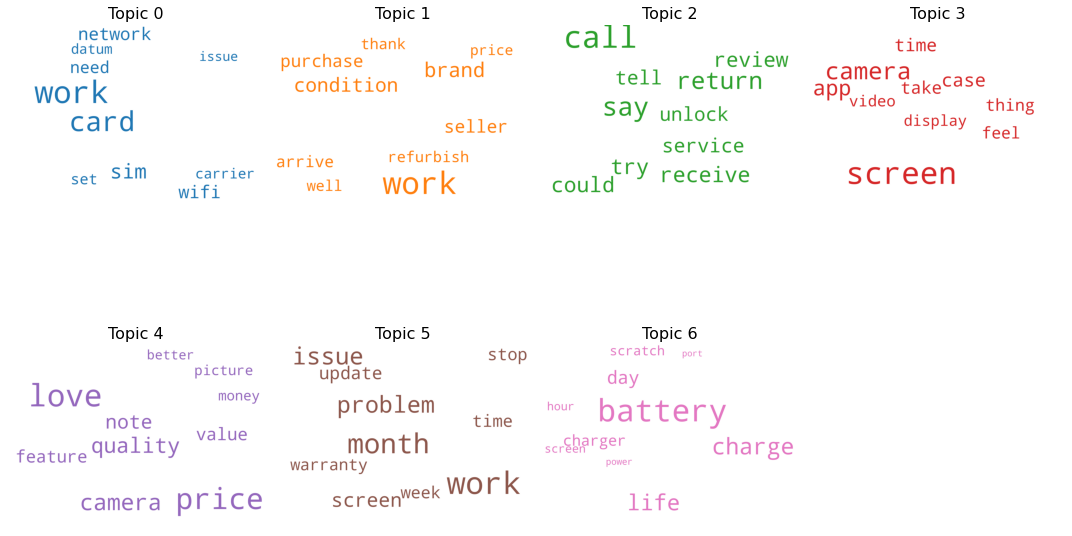

In [12]:
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = best_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(15,15))
axes = axes.ravel()
axes[7].set_visible(False)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    if i>=6:
        break


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout(h_pad=-30)
plt.show()

#remove great,nice,get,would,buy,come,also,really,get,best,go,look,make,flagship,drop,product,send,even,love,ever,expect,use,far

In [13]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, corpus, dictionary=best_model.id2word )
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.201430  0.019385       1        1  33.643005
2     -0.014325 -0.102689       2        1  18.936115
4     -0.158067  0.301504       3        1  11.678383
6     -0.160913 -0.165704       4        1  10.685168
5      0.085258 -0.175380       5        1   9.886740
0      0.134643  0.001709       6        1   8.831198
1      0.314833  0.121175       7        1   6.339388, topic_info=           Term          Freq         Total Category  logprob  loglift
88         work  26027.000000  26027.000000  Default  30.0000  30.0000
5       battery  16765.000000  16765.000000  Default  29.0000  29.0000
155        love  10136.000000  10136.000000  Default  28.0000  28.0000
11       charge   8184.000000   8184.000000  Default  27.0000  27.0000
139       price  11253.000000  11253.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
139       price   1562.103760  11253.091797   Topic7  -3.7637   0.7838
77         time   1325.906372   9863.605469   Topic7  -3.9276   0.7516
169        deal    625.268311   1998.850952   Topic7  -4.6793   1.5962
230      highly    454.008331   1075.289917   Topic7  -4.9994   1.8962
20   definitely    555.585632   1894.713867   Topic7  -4.7975   1.5316

[476 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
368       2  0.010872  absolutely
368       3  0.697253  absolutely
368       4  0.029717  absolutely
368       5  0.107270  absolutely
368       6  0.057259  absolutely
...     ...       ...         ...
276       4  0.052060        year
276       5  0.427727        year
1748      5  0.995721   yesterday
2566      3  0.997984     youtube
1985      7  0.978382        zone

[898 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 5, 7, 6, 1, 2])

In [101]:
combined_df = pd.concat([df_dominant_topic,new_reviews],axis=1)